# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",100)
%matplotlib inline

%%bash
rm dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    kdd_test__2labels = pd.read_pickle("dataset/kdd_test__2labels.pkl")

    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]
    
    x_test__input = dataset.kdd_test__2labels.drop(output_columns_2labels, axis = 1)
    y_test_ = dataset.kdd_test__2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    x_test_ = ss.transform(x_test__input)

    y_train = y_output.values
    y_test = y_test.values
    y_test_ = y_test_.values

preprocess.x_train.shape

(125973, 122)

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 18

    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
            #hidden_encoder = tf.layers.dense(self.x, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            #hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(hidden_encoder, classes, activation=tf.nn.softmax)
            
        with tf.variable_scope("Loss"):
            
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            #loss = tf.clip_by_value(loss, -1e-1, 1e-1)
            #loss = tf.where(tf.is_nan(loss), 1e-1, loss)
            #loss = tf.where(tf.equal(loss, -1e-1), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-1), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = loss
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [12]:
import collections
import time
import sklearn.metrics as me 

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'f1_score', 'test_score_20', 'f1_score_20', 'time_taken'])

    predictions = {}
    predictions_ = {}

    results = []
    
    best_acc = 0
    best_acc_global = 0
    
    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_dense_only_nsl_kdd/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for c, lr in enumerate(lrs):
                for epoch in range(1, (epochs+1)):
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                               net.regularized_loss, 
                                                               ], #net.summary_op
                                                              feed_dict={net.x: x_train[i,:], 
                                                                         net.y_: y_train[i,:], 
                                                                         net.keep_prob:0.5, net.lr:lr})

                        train_batch()
                        #summary_writer_train.add_summary(summary_str, epoch)
                        while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1):
                            print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_dense_only_nsl_kdd/hidden_layers_{}_features_count_{}'
                                                                         .format(epochs,h,f)))
                            train_batch()


                    valid_accuracy = sess.run(net.tf_accuracy, #net.summary_op 
                                                          feed_dict={net.x: x_valid, 
                                                                     net.y_: y_valid, 
                                                                     net.keep_prob:1, net.lr:lr})
                    #summary_writer_valid.add_summary(summary_str, epoch)


                    accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test, 
                                                                             net.y_: preprocess.y_test, 
                                                                             net.keep_prob:1, net.lr:lr})
                    f1_score = me.f1_score(actual_value, pred_value)
                    accuracy_, pred_value_, actual_value_, y_pred_ = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test_, 
                                                                             net.y_: preprocess.y_test_, 
                                                                             net.keep_prob:1, net.lr:lr})
                    f1_score_ = me.f1_score(actual_value_, pred_value_)
                    
                    print("Step {} | Training Loss: {:.6f} | Validation Accuracy: {:.6f}".format(epoch, train_loss, valid_accuracy))
                    print("Accuracy on Test data: {}, {}".format(accuracy, accuracy_))

                    if accuracy > Train.best_acc_global:
                        Train.best_acc_global = accuracy
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        Train.pred_value_ = pred_value_
                        Train.actual_value_ = actual_value_
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:
                        Train.best_acc = accuracy

                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_dense_only_nsl_kdd/hidden_layers_{}_features_count_{}".format(h,f),
                                        global_step = epochs)
                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value, "Actual":actual_value})
                        curr_pred_ = pd.DataFrame({"Attack_prob":y_pred_[:,-2], "Normal_prob":y_pred_[:, -1], "Prediction":pred_value_, "Actual": actual_value_})
                        
                        Train.predictions.update({"{}_{}_{}".format((epoch+1)*(c+1),f,h):(curr_pred, 
                                                   Train.result((epoch+1)*(c+1), f, h, valid_accuracy, accuracy, f1_score, accuracy_, f1_score_, time.perf_counter() - start_time))})
                        Train.predictions_.update({"{}_{}_{}".format((epoch+1)*(c+1),f,h):(curr_pred_, 
                                                   Train.result((epoch+1)*(c+1), f, h, valid_accuracy, accuracy, f1_score, accuracy_, f1_score_, time.perf_counter() - start_time))})

                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))


In [9]:
import itertools

df_results = []
past_scores = []

class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]

    def start_training():
        print("********************************** Training ******************************")

        global df_results
        global past_scores
        Train.predictions = {}
        Train.predictions_ = {}

        Train.results = []
    
        
        features_arr = [1, 12, 24, 48, 122]
        hidden_layers_arr = [1, 3]

        epochs = [5]
        lrs = [1e-5, 1e-6]
        print("********************************** Entering Loop ******************************")

        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)
            
        dict1 = {}
        dict1_ = {}
        dict2 = []

        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)

        for k, (v1_, v2) in Train.predictions_.items():
            dict1_.update({k: v1_})

        Train.predictions = dict1
        Train.predictions_ = dict1_
        
        Train.results = dict2
        df_results = pd.DataFrame(Train.results)

        #temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        if not os.path.isfile('dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl'):
            past_scores = df_results
        else:
            past_scores = pd.read_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl")
            past_scores = past_scores.append(df_results, ignore_index=True)
        past_scores.to_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl")

In [10]:
#%%timeit -r 10
#capture
Hyperparameters.start_training()

********************************** Training ******************************
********************************** Entering Loop ******************************
Current Layer Attributes - epochs:5 hidden layers:1 features count:1
Step 1 | Training Loss: 0.673428 | Validation Accuracy: 0.688919
Accuracy on Test data: 0.7459191083908081, 0.5784810185432434
Step 2 | Training Loss: 0.626510 | Validation Accuracy: 0.768535
Accuracy on Test data: 0.7801188826560974, 0.6107172966003418
Step 3 | Training Loss: 0.587754 | Validation Accuracy: 0.838943
Accuracy on Test data: 0.804737389087677, 0.6439662575721741
Step 4 | Training Loss: 0.550928 | Validation Accuracy: 0.882283
Accuracy on Test data: 0.8132097125053406, 0.6544303894042969
Step 5 | Training Loss: 0.515119 | Validation Accuracy: 0.905858
Accuracy on Test data: 0.815072774887085, 0.6548523306846619
Step 1 | Training Loss: 0.530951 | Validation Accuracy: 0.908557
Accuracy on Test data: 0.8155163526535034, 0.6555274128913879
Step 2 | Trainin

/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Step 1 | Training Loss: 0.693090 | Validation Accuracy: 0.533180
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 2 | Training Loss: 0.693041 | Validation Accuracy: 0.539848
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 3 | Training Loss: 0.693034 | Validation Accuracy: 0.538339
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 4 | Training Loss: 0.692749 | Validation Accuracy: 0.539768
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 5 | Training Loss: 0.692727 | Validation Accuracy: 0.534132
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 1 | Training Loss: 0.692839 | Validation Accuracy: 0.528100
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 2 | Training Loss: 0.692817 | Validation Accuracy: 0.535164
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 3 | Training Loss: 0.692969 | Validation Accuracy: 0.528417
Accuracy on Test data: 0.4307576

In [11]:
#g = df_results.groupby(by=['no_of_features'])
#idx = g['test_score'].transform(max) == df_results['test_score']
#df_results[idx].sort_values(by = 'test_score', ascending = False)

In [12]:
#g = df_results.groupby(by=['no_of_features'])
#idx = g['test_score_20'].transform(max) == df_results['test_score_20']
#df_results[idx].sort_values(by = 'test_score_20', ascending = False)

In [13]:
#df_results.sort_values(by = 'test_score', ascending = False)

In [14]:
#Train.predictions_

In [15]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_dense_only_nsl_kdd_predictions.pkl")
pd.Panel(Train.predictions_).to_pickle("dataset/tf_dense_only_nsl_kdd_predictions__.pkl")

df_results.to_pickle("dataset/tf_dense_only_nsl_kdd_scores.pkl")


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Negative", "\n False Positive \n Type II Error"],
             ["\n False Negative \n Type I Error", "\n True Positive"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix

    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, ['Normal', 'Attack'], normalize = False)


In [3]:
#plot(actual_value = Train.actual_value, pred_value = Train.pred_value)

In [4]:
#plot(actual_value = Train.actual_value_, pred_value = Train.pred_value_)

In [5]:
past_scores = pd.read_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl")

In [6]:
past_scores.sort_values(by='f1_score',ascending=False)

,epoch,no_of_features,hidden_layers,train_score,test_score,f1_score,test_score_20,f1_score_20,time_taken
168,10,12,3,0.855215,0.894562,0.910884,0.830886,0.899950,13.064114
169,12,12,3,0.857755,0.894606,0.910878,0.830633,0.899755,14.526398
167,8,12,3,0.858152,0.894163,0.910590,0.830633,0.899835,11.607629
166,6,12,3,0.851405,0.893941,0.910493,0.831055,0.900170,10.226502
164,4,12,3,0.853548,0.893719,0.910383,0.831139,0.900304,8.766340
118,3,48,3,0.825687,0.890126,0.907881,0.833924,0.902158,3.292134
186,2,122,3,0.855056,0.887287,0.904484,0.820338,0.893171,2.023987
55,5,48,3,0.898635,0.885158,0.899608,0.797553,0.875924,7.526736
165,5,12,3,0.826957,0.878770,0.899496,0.826835,0.898627,5.834742
47,12,12,3,0.888316,0.874867,0.891854,0.787679,0.871080,16.187101


In [8]:
psg = past_scores.sort_values(by='test_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
psg.first().sort_values(by='test_score', ascending=False)

,,epoch,train_score,test_score,f1_score,test_score_20,f1_score_20,time_taken
no_of_features,hidden_layers,,,,,,,
12,3,12,0.857755,0.894606,0.910878,0.830633,0.899755,14.526398
48,3,3,0.825687,0.890126,0.907881,0.833924,0.902158,3.292134
122,3,2,0.855056,0.887287,0.904484,0.820338,0.893171,2.023987
24,3,6,0.863312,0.874823,0.889498,0.813840,0.881830,7.621298
122,1,12,0.924988,0.869855,0.874390,0.757215,0.831587,11.076009
12,1,12,0.919114,0.861293,0.868949,0.741435,0.825314,11.106206
24,1,12,0.930386,0.834102,0.843828,0.695190,0.794235,11.245759
48,1,12,0.909986,0.832816,0.839172,0.689873,0.785452,10.797683
1,1,12,0.914590,0.821726,0.824398,0.667004,0.761657,11.076122


In [9]:
psg.mean().sort_values(by='test_score', ascending=False)

,,epoch,train_score,test_score,f1_score,test_score_20,f1_score_20,time_taken
no_of_features,hidden_layers,,,,,,,
122,3,3.333333,0.895389,0.829371,0.832344,0.692368,0.779285,5.084863
12,3,6.250000,0.822525,0.825593,0.838426,0.742057,0.828262,8.878852
48,3,4.928571,0.807702,0.809404,0.824254,0.729717,0.816798,7.155954
122,1,6.086957,0.873620,0.800608,0.788811,0.655799,0.736685,6.602675
24,1,6.250000,0.869139,0.772242,0.776736,0.620840,0.723665,6.771927
48,1,6.000000,0.856225,0.769009,0.759046,0.610660,0.703376,6.251669
1,1,6.250000,0.845352,0.761455,0.737676,0.588270,0.676262,6.768404
12,1,6.250000,0.865167,0.749634,0.732707,0.558087,0.642448,6.587167
24,3,5.750000,0.807374,0.724998,0.722034,0.612245,0.711898,7.749273


In [13]:
Train.predictions = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_predictions.pkl")
Train.predictions_ = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_predictions__.pkl")

In [14]:
#epoch_nof_hidden
Train.predictions["12_12_3"]

,Actual,Attack_prob,Normal_prob,Prediction
0,1.0,0.230107,0.769893,1.0
1,1.0,0.235818,0.764182,1.0
2,0.0,0.362311,0.637689,1.0
3,1.0,0.282255,0.717745,1.0
4,1.0,0.197159,0.802841,1.0
5,0.0,0.696406,0.303594,0.0
6,0.0,0.478545,0.521455,1.0
7,1.0,0.156524,0.843476,1.0
8,0.0,0.689525,0.310475,0.0
9,1.0,0.031989,0.968011,1.0


In [15]:
Train.predictions_["12_12_3"]

,Actual,Attack_prob,Normal_prob,Prediction
0,1.0,4.081985e-01,0.591802,1.0
1,1.0,5.129235e-01,0.487077,0.0
2,1.0,6.105986e-03,0.993894,1.0
3,0.0,4.317109e-01,0.568289,1.0
4,1.0,1.202209e-02,0.987978,1.0
5,1.0,6.364901e-01,0.363510,0.0
6,1.0,1.391150e-02,0.986089,1.0
7,1.0,3.760841e-01,0.623916,1.0
8,0.0,4.293991e-01,0.570601,1.0
9,0.0,3.886536e-01,0.611346,1.0


In [16]:
df = Train.predictions["12_12_3"].dropna()
df_ = Train.predictions_["12_12_3"].dropna()

In [21]:
from sklearn import metrics as me
def get_score(y_true, y_pred):
    f1 = me.f1_score(y_true, y_pred)
    pre = me.precision_score(y_true, y_pred)
    rec = me.recall_score(y_true, y_pred)
    acc = me.accuracy_score(y_true, y_pred)
    return {"F1 Score":f1, "Precision":pre, "Recall":rec, "Accuracy":acc}


In [28]:
from sklearn import metrics as me

scores = get_score(df.loc[:,'Actual'].values.astype(int),
                df.loc[:,'Prediction'].values.astype(int))
scores.update({"Scenario":"Train+/Test+"})
score_df = pd.DataFrame(scores, index=[0])

scores = get_score(df_.loc[:,'Actual'].values.astype(int),
                df_.loc[:,'Prediction'].values.astype(int))
scores.update({"Scenario":"Train+/Test-"})

score_df = score_df.append(pd.DataFrame(scores, index=[1]))

score_df

,Accuracy,F1 Score,Precision,Recall,Scenario
0,0.894606,0.910878,0.878137,0.946154,Train+/Test+
1,0.830633,0.899755,0.872518,0.928748,Train+/Test-


In [29]:
df.groupby(by="Actual").Actual.count()

Actual
0.0     9711
1.0    12833
Name: Actual, dtype: int64

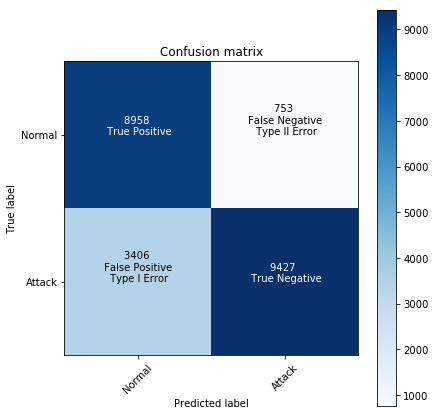

In [30]:
plot(actual_value = df.loc[:,'Actual'].values.astype(int),
     pred_value = df.loc[:,'Prediction'].values.astype(int))

In [31]:
df_.groupby(by="Actual").Actual.count()

Actual
0.0    2152
1.0    9698
Name: Actual, dtype: int64

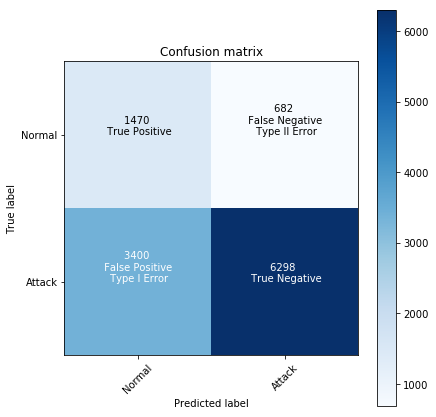

In [32]:
plot(actual_value = df_.loc[:,'Actual'].values.astype(int),
     pred_value = df_.loc[:,'Prediction'].values.astype(int))

In [33]:
from scipy import stats

def fn(x):
    #print(x)
    return stats.norm.interval(0.95, loc=x.f1_score.mean(), scale=x.f1_score.std())
psg.apply(fn)

/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1907: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1908: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


no_of_features  hidden_layers
1               1                  (0.46458786874, 1.01076358441)
                3                                      (nan, nan)
12              1                (0.549081633853, 0.916331648684)
                3                 (0.639433709421, 1.03741828315)
24              1                (0.638652754621, 0.914818438628)
                3                (0.444861154322, 0.999207435556)
48              1                (0.533239339446, 0.984852258506)
                3                 (0.585151939604, 1.06335639119)
122             1                (0.581870630479, 0.995752331818)
                3                (0.687123021932, 0.977564237438)
dtype: object